In [ ]:
#### 드라이브마운트


In [3]:
#### zip파일 압축해제
%cd /content/drive/MyDrive/한경IT_5차/data
%pwd

/content/drive/MyDrive/한경IT_5차/data


'/content/drive/MyDrive/한경IT_5차/data'

In [4]:
!ls

flower_photos.zip


In [6]:

!unzip -qq "/content/drive/MyDrive/한경IT_5차/data/flower_photos.zip"

In [1]:
### 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [2]:
batch_size = 32   # 한셋트에 몇개의 자료를 넣을것인가? 기본 32로 많이하나 조정해도됨. 숫자를 적게할수록 처리속도가 느려짐
img_height = 180
img_width = 180

data_dir='/content/drive/MyDrive/한경IT_5차/data/flower_photos/'
# 전체 3670개의 이미지자료에서 80%의 2936개를 트레이닝(훈련)자료로 세팅함
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,   # 3670*80%=2936, subset이 training여서 1-0.2임
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)     # 2936개의이미지를 32개씩 세트해서 묶음. 즉 92개세트가 나옴 (92세트*32)

# 전체 3670개의 이미지자료에서 20%의 734개를 테스트데이터로 세팅함
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# train_ds에 할당된 data_dir 폴더명
class_names = train_ds.class_names
print(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [3]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [4]:
preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [5]:
base_model = VGG16(input_shape=(180,180,3),
                   include_top=False,
                   weights='imagenet')
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(5,activation='softmax')

In [6]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs =prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [7]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # y값이 원핫인코딩이 안되어 있어서임
              metrics=['accuracy'])


# 모델 최적화를 위한 설정 구간입니다.

modelpath="'/content/drive/MyDrive/한경IT_5차/model/flower_CNN_전이학습_에포크100.hdf5"

checkpointer = ModelCheckpoint(filepath=modelpath, 
                               monitor='val_loss',       # val_loss값을 기준으로
                               verbose=1,                # 실행결과를 화면에 출력함. verbose=0하면 실행결과가 화면에 나타나지않음
                               save_best_only=True)  # 가장좋은(즉 loss숫자가 가장 낮은) 모델을 저장함

early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=5) # 실행하다가 5번이상 더 좋은 결과가 없으면 중단

epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping_callback,checkpointer]
)

Epoch 1/100
92/92 [==============================] - ETA: 0s - loss: 1.5264 - accuracy: 0.3604
Epoch 1: val_loss improved from inf to 1.29014, saving model to '/content/drive/MyDrive/한경IT_5차/model/flower_CNN_전이학습_에포크100.hdf5
92/92 [==============================] - 87s 907ms/step - loss: 1.5264 - accuracy: 0.3604 - val_loss: 1.2901 - val_accuracy: 0.6131
Epoch 2/100
91/92 [============================>.] - ETA: 0s - loss: 1.2262 - accuracy: 0.5879
Epoch 2: val_loss improved from 1.29014 to 1.09783, saving model to '/content/drive/MyDrive/한경IT_5차/model/flower_CNN_전이학습_에포크100.hdf5
92/92 [==============================] - 5s 48ms/step - loss: 1.2265 - accuracy: 0.5886 - val_loss: 1.0978 - val_accuracy: 0.6689
Epoch 3/100
92/92 [==============================] - ETA: 0s - loss: 1.0701 - accuracy: 0.6461
Epoch 3: val_loss improved from 1.09783 to 0.98996, saving model to '/content/drive/MyDrive/한경IT_5차/model/flower_CNN_전이학습_에포크100.hdf5
92/92 [==============================] -

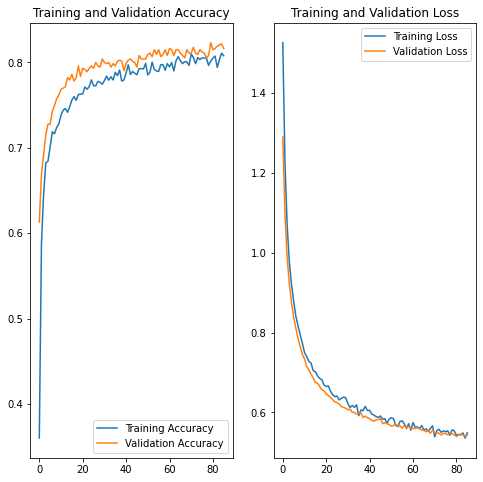

In [8]:
## 차트작성함
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()